# FEL BNN Training

This is an intial attempt at training BNNs to predict a median prediction with 95% confidence intervals for FEL photon pulse energy predictions.
This notebook is based heavily on the examples available in the blitz-bayesian-pytorch [documentation](https://pypi.org/project/blitz-bayesian-pytorch/).


This notebook has been used to train simple BNNs for comparison to the QR models. This notebook is notebook is not optimized, or as clean as it can be!

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
import pickle

import matplotlib.style
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 15}
mpl.rc('font', **font)
### colorblind-friendly colors
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

In [2]:
# full scale data
PATH = "knet2_76D/"
X_ = np.load(PATH +'X_fel.npy')  
Y_ = np.load(PATH +'Y_fel.npy')

In [3]:
mask=(Y_<5) & (Y_>0.2)

Yf=Y_[mask]
Xf=X_[mask[:,0],:]

print("Input shape:" + str(Xf.shape))
print("Output shape:" + str(Yf.shape))

Input shape:(271543, 76)
Output shape:(271543,)


In [4]:
Xf = Xf
Yf = Yf

print("Input shape:" + str(Xf.shape))
print("Output shape:" + str(Yf.shape))

Input shape:(271543, 76)
Output shape:(271543,)


(array([28709., 32185., 31572., 34754., 47335., 42230., 28985., 18356.,
         5922.,  1495.]),
 array([0.20001711, 0.67994743, 1.15987775, 1.63980807, 2.11973839,
        2.59966871, 3.07959903, 3.55952935, 4.03945968, 4.51939   ,
        4.99932032]),
 <BarContainer object of 10 artists>)

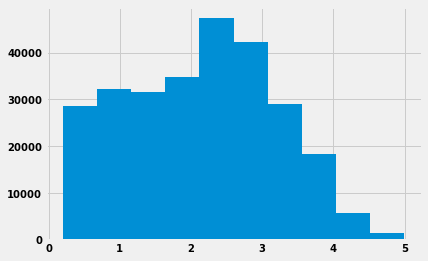

In [5]:
plt.hist(Yf)

In [6]:
scalerx = MinMaxScaler()
scalerx.fit(Xf)
xf=scalerx.transform(Xf)


Yf=Yf[:,np.newaxis]
scalery=MinMaxScaler()
scalery.fit(Yf)
yf=scalery.transform(Yf)



with open(PATH + "BNN/input_trans2.pkl", 'wb') as f:
    pickle.dump(scalerx, f)

with open(PATH + "BNN/output_trans2.pkl", 'wb') as f:
    pickle.dump(scalery, f)

def calc_mse_and_mae(meas, pred):
    mse = np.mean((meas - pred)**2)
    mae = np.mean(np.abs(meas-pred))
    return mse, mae

In [7]:
X_train, X_test, y_train, y_test = train_test_split(xf, yf, test_size=0.2, random_state=42)

input_dict = {}
input_dict["train"] = X_train
input_dict["test"] = X_test

output_dict = {}
output_dict["train"] = y_train
output_dict["test"] = y_test

with open(PATH + "BNN/inputs2.pkl", 'wb') as f:
    pickle.dump(input_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(PATH + "BNN/outputs2.pkl", 'wb') as f:
    pickle.dump(output_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

In [9]:
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        #self.linear = nn.Linear(input_dim, output_dim)
        self.blinear1 = BayesianLinear(input_dim, 80)
        self.blinear2 = BayesianLinear(80, 60)
        self.blinear3 = BayesianLinear(60, 50)
        self.blinear4 = BayesianLinear(50, 40)
        self.blinear5 = BayesianLinear(40, 20)
        self.blinear6 = BayesianLinear(20, 20)
        self.blinear7 = BayesianLinear(20, 20)
        self.blinear8 = BayesianLinear(20, output_dim)
        
    def forward(self, x):
        x_ = self.blinear1(x)
        x_=self.blinear2(x_)
        x_=self.blinear3(x_)
        x_=self.blinear4(x_)
        x_=self.blinear5(x_)
        x_=self.blinear6(x_)
        x_=self.blinear7(x_)
        return self.blinear8(x_)   
    

In [10]:
def evaluate_regression(regressor,
                        X,
                        y,
                        samples = 100,
                        std_multiplier = 2):
    preds = [regressor(X) for i in range(samples)]
    preds = torch.stack(preds)
    means = preds.mean(axis=0)
    stds = preds.std(axis=0)
    ci_upper = means + (std_multiplier * stds)
    ci_lower = means - (std_multiplier * stds)
    ic_acc = (ci_lower <= y) * (ci_upper >= y)
    ic_acc = ic_acc.float().mean()
    return ic_acc, (ci_upper >= y).float().mean(), (ci_lower <= y).float().mean()

CI acc: 0.3691, CI upper acc: 0.6187, CI lower acc: 0.7504
CI acc: 0.3476, CI upper acc: 0.6081, CI lower acc: 0.7395
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
Final Coverage and Loss
CI acc: 0.4315, CI upper acc: 0.7106, CI lower acc: 0.7209
Loss: 0.0509
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


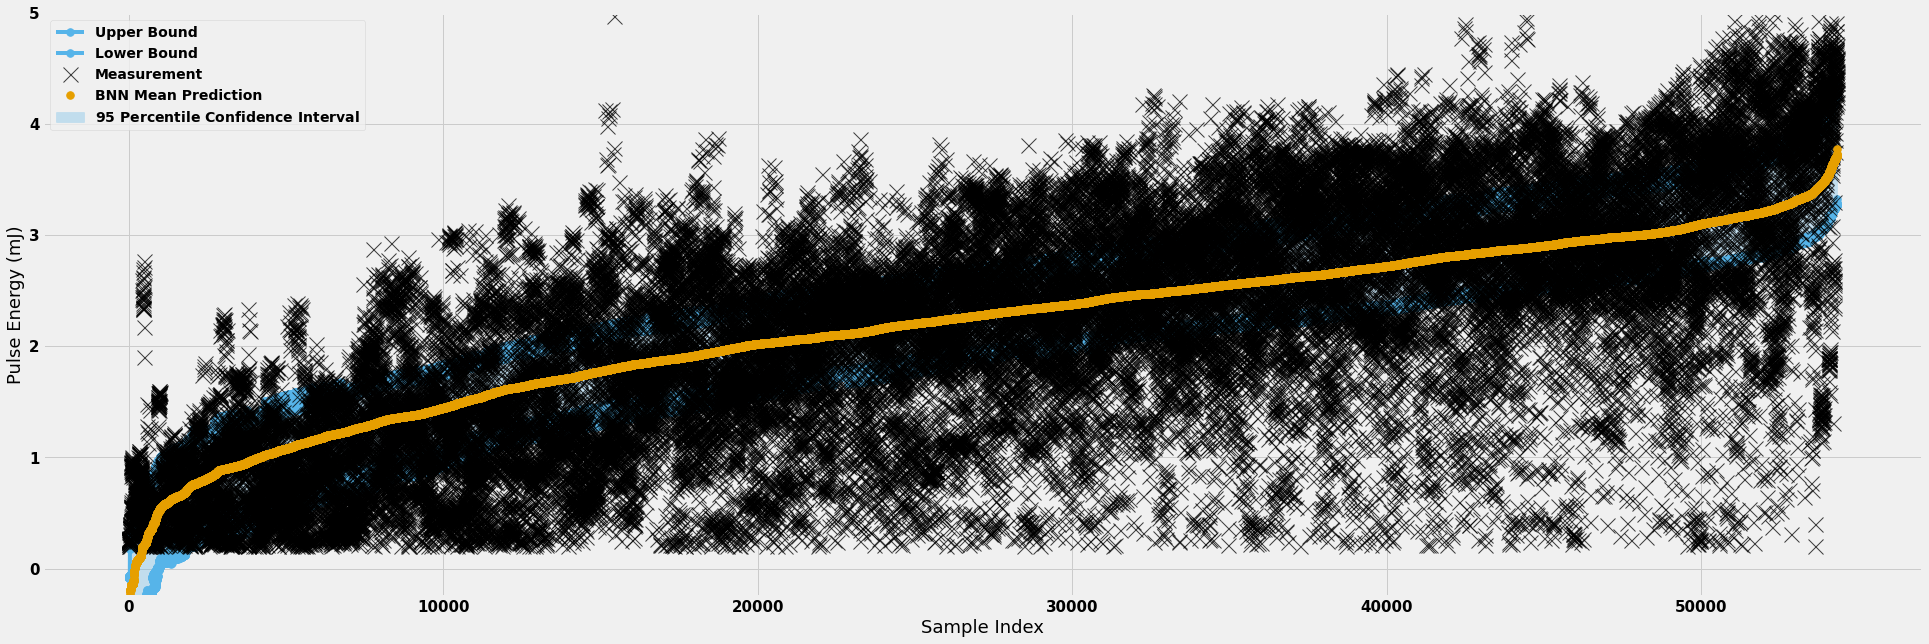

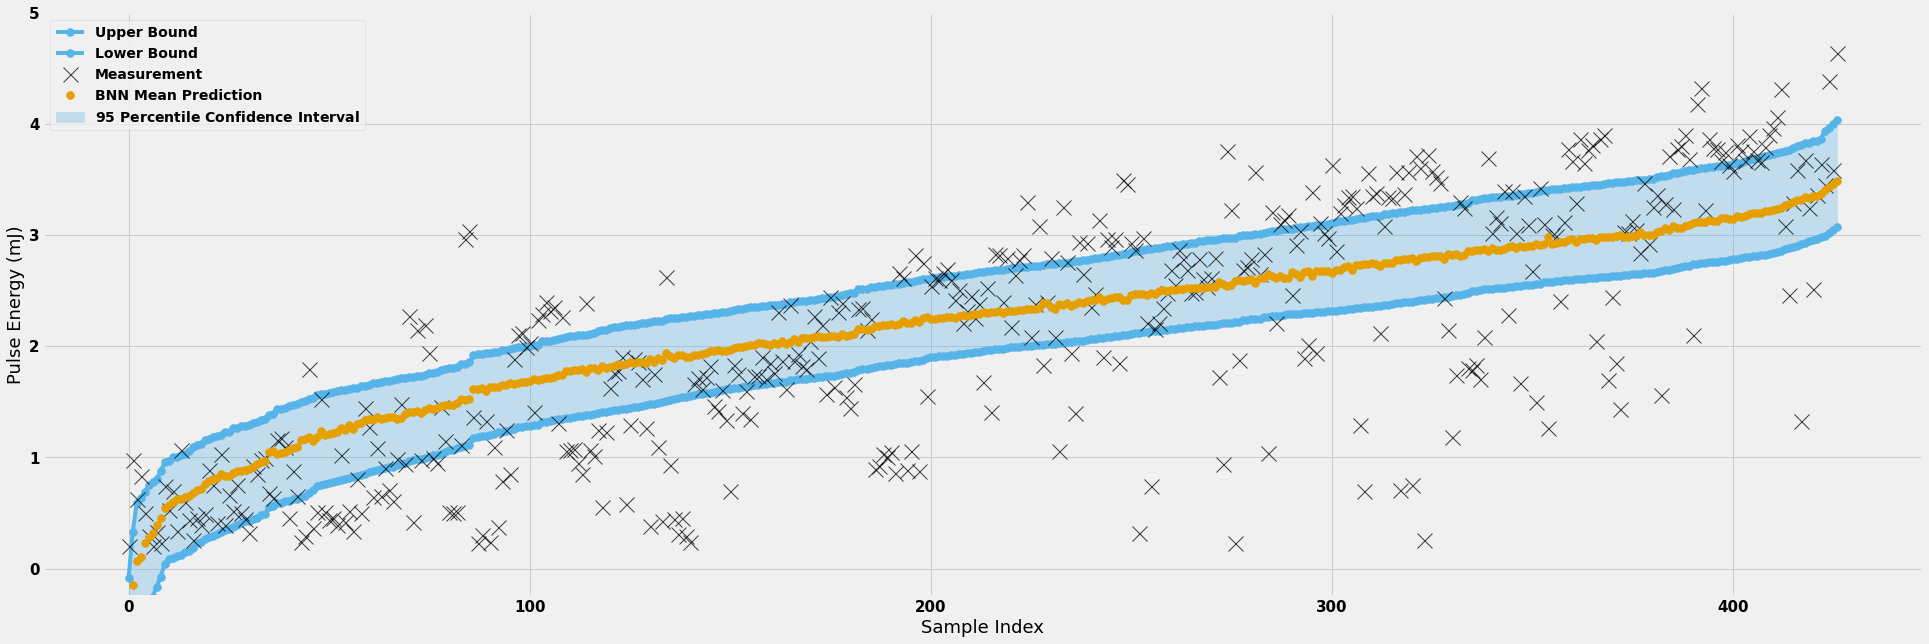

MSE = 0.52
MAE = 0.56


In [23]:
SAVEPATH = PATH + "BNN/model_forprint_2_"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regressor = BayesianRegressor(76, 1).to(device)
optimizer = optim.Adam(regressor.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()


ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=2048, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=2048, shuffle=True)


iteration = 0
for epoch in range(2):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = regressor.sample_elbo(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=3,
                           complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%100==0:
            ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
                                                                        X_test.to(device),
                                                                        y_test.to(device),
                                                                        samples=100,
                                                                        std_multiplier=2)
            
            print("CI acc: {:.4f}, CI upper acc: {:.4f}, CI lower acc: {:.4f}".format(ic_acc, under_ci_upper, over_ci_lower))
            
ic_acc, under_ci_upper, over_ci_lower = evaluate_regression(regressor,
                                                            X_test.to(device),
                                                            y_test.to(device),
                                                            samples=100,
                                                            std_multiplier=2) 
print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")
print("Final Coverage and Loss")
print("CI acc: {:.4f}, CI upper acc: {:.4f}, CI lower acc: {:.4f}".format(ic_acc, under_ci_upper, over_ci_lower))
print("Loss: {:.4f}".format(loss))
print("-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_")

##### Preparing predictions and intervals!

num=100
tempnum=y_test.shape[0]
preds=np.zeros((tempnum,num))
for i in range(num):
    temp=regressor.forward(X_test)
    pred1=temp.detach().numpy()
    preds[:,i]=pred1[:,0]
tempmean=np.mean(preds,axis=1)

tempstd=np.std(preds,axis=1)
tempmean.shape,tempstd.shape
tempmedian=np.quantile(preds,0.5,axis=1)
temp075=np.quantile(preds,0.975,axis=1)
temp025=np.quantile(preds,0.025,axis=1)


yreals=scalery.inverse_transform(y_test)
ymedian=scalery.inverse_transform(tempmedian[:,np.newaxis])
yu=scalery.inverse_transform(temp075[:,np.newaxis])
yl=scalery.inverse_transform(temp025[:,np.newaxis])


idx=np.argsort(ymedian[:,0])
base=np.arange(len(idx))
lower=yl[idx,0]
upper=yu[idx,0]


##### Plotting!!! 

markersize = 15
plt.figure(figsize=(30,10))
plt.plot(yu[idx,0],'.-', color = colors[2], markersize = markersize,label = "Upper Bound")
plt.plot(yl[idx,0],'.-', color = colors[2], markersize = markersize,label = "Lower Bound")
plt.plot(yreals[idx,0],'x', color = colors[0], alpha = 0.75, markersize = markersize, label= "Measurement")
plt.plot(ymedian[idx,0],'.', color = colors[1],markersize = markersize,label= "BNN Mean Prediction")
plt.fill_between(base,lower,upper,color = colors[2], alpha=0.3,label="$95$ Percentile Confidence Interval") 
plt.ylim(-0.25,5)
plt.xlabel('Sample Index')
plt.ylabel('Pulse Energy (mJ)')
plt.legend(prop={'size': 14})
plt.savefig("BNN-test-sortedmed2.png")
plt.show()


lbinds = np.argsort(yl[:,0])
ubinds = np.argsort(yu[:,0])

n = 500
seq = []
step = int(yu.shape[0]/n)

for i in range(n):
        temp1=lbinds[i*step:(i+1)*step]
        temp2=ubinds[i*step:(i+1)*step]
        for num in temp1:
            if(num in temp2):
                seq.append(num)
                break
                



base=np.arange(len(seq))
lower=yl[seq,0]
upper=yu[seq,0]

plt.figure(figsize=(30,10))

plt.plot(yu[seq,0],'.-', color = colors[2], markersize = markersize,label = "Upper Bound")
plt.plot(yl[seq,0],'.-', color = colors[2], markersize = markersize,label = "Lower Bound")

plt.plot(yreals[seq,0],'x', color = colors[0], alpha = 0.75, markersize = markersize,label= "Measurement")
plt.plot(ymedian[seq,0],'.', color = colors[1],markersize = markersize,label= "BNN Mean Prediction")

plt.fill_between(base,lower,upper, color = colors[2], alpha=0.3,label="$95$ Percentile Confidence Interval") 

plt.xlabel('Sample Index')
plt.ylabel('Pulse Energy (mJ)')
plt.legend(prop={'size': 14})
plt.ylim(-0.25,5)
plt.savefig("BNN-test-sortedseq2.png")
plt.show()

mse, mae = calc_mse_and_mae(yreals, ymedian)
print("MSE = {:2.2f}".format(mse))
print("MAE = {:2.2f}".format(mae))

torch.save(regressor.state_dict(), SAVEPATH)

In [29]:
coverage = np.logical_and(yreals[:,0] > yl[:,0], yreals[:,0] < yu[:,0])
print(np.shape(coverage))
coverage = np.array([int(elem) for elem in coverage])
coverage_percent = 100*np.sum(coverage)/len(yreals)
print("The percent of measured values within the confidence interval is: {:2.2f}%".format(coverage_percent))

(54309,)
The percent of measured values within the confidence interval is: 44.64%


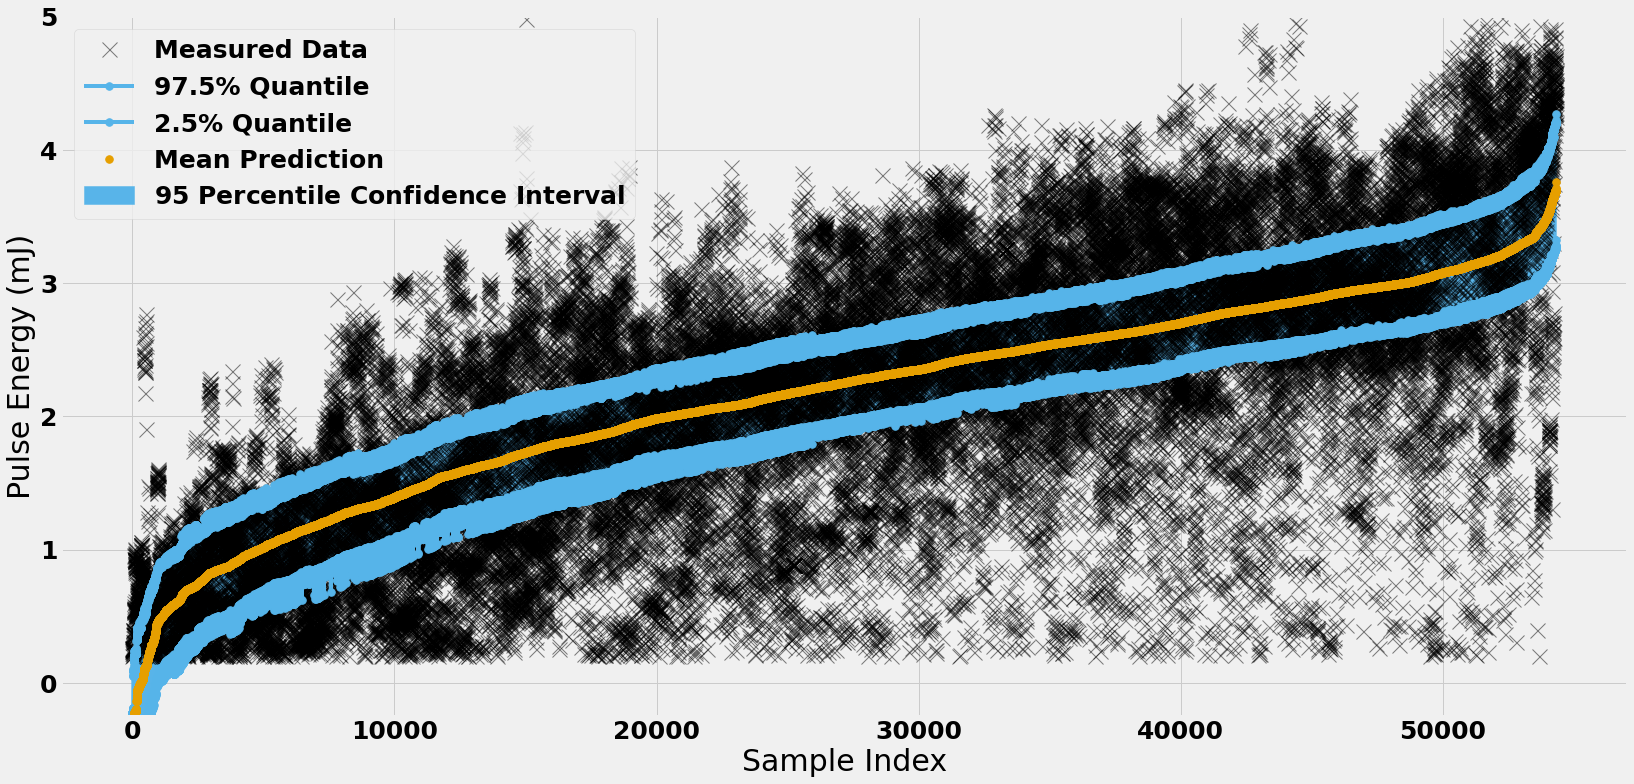

In [100]:
mpl.style.use('seaborn-bright')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 25}
mpl.rc('font', **font)


num=100
tempnum=y_test.shape[0]
preds=np.zeros((tempnum,num))
for i in range(num):
    temp=regressor.forward(X_test)
    pred1=temp.detach().numpy()
    preds[:,i]=pred1[:,0]
tempmean=np.mean(preds,axis=1)

tempstd=np.std(preds,axis=1)
tempmean.shape,tempstd.shape
tempmedian=np.quantile(preds,0.5,axis=1)
temp075=np.quantile(preds,0.975,axis=1)
temp025=np.quantile(preds,0.025,axis=1)


yreals=scalery.inverse_transform(y_test)
ymedian=scalery.inverse_transform(tempmedian[:,np.newaxis])
yu=scalery.inverse_transform(temp075[:,np.newaxis])
yl=scalery.inverse_transform(temp025[:,np.newaxis])


idx=np.argsort(ymedian[:,0])
base=np.arange(len(idx))
lower=yl[idx,0]
upper=yu[idx,0]

markersize = 15
plt.figure(figsize=(25,12))
#plt.title("BNN Results: Uncertainty Estimates and Mean Prediction for FEL Pulse Energy")
plt.plot(yreals[idx,0],'x', color = colors[0], alpha = 0.5, markersize = markersize, label= "Measured Data")
plt.plot(yu[idx,0],'.-', color = colors[2], markersize = markersize,label = "97.5% Quantile")
plt.plot(yl[idx,0],'.-', color = colors[2], markersize = markersize,label = "2.5% Quantile")

plt.plot(ymedian[idx,0],'.', color = colors[1],markersize = markersize,label= "Mean Prediction")
plt.fill_between(base,lower,upper,color = colors[2], alpha=0.99,label="$95$ Percentile Confidence Interval") 
plt.xlabel('Sample Index')
plt.ylabel('Pulse Energy (mJ)')
plt.ylim(-0.25, 5)

plt.legend(prop={'size': 25},loc='upper left')

plt.savefig("BNN-sorted.png", transparent = True)
plt.show()



In [101]:
num=100
tempnum=yf.shape[0]
preds=np.zeros((tempnum,num))
for i in range(num):
    temp=regressor.forward(torch.tensor(xf).float())
    pred1=temp.detach().numpy()
    preds[:,i]=pred1[:,0]
tempmean=np.mean(preds,axis=1)

tempstd=np.std(preds,axis=1)
tempmean.shape,tempstd.shape
tempmedian=np.quantile(preds,0.5,axis=1)
temp075=np.quantile(preds,0.975,axis=1)
temp025=np.quantile(preds,0.025,axis=1)


yreals=scalery.inverse_transform(yf)
ymedian=scalery.inverse_transform(tempmedian[:,np.newaxis])
yu=scalery.inverse_transform(temp075[:,np.newaxis])
yl=scalery.inverse_transform(temp025[:,np.newaxis])


In [102]:
# base = np.arange(np.shape(yreals)[0])
# plt.figure(figsize=(25,7))
# #plt.title("BNN Results Mean Prediction and Uncertainty Estimates for FEL Pulse Energy, Chronological Data")
# plt.plot(yu[:,0],'.-', color = colors[2], markersize = markersize,label = "Upper Bound")
# plt.plot(yl[:,0],'.-', color = colors[2], markersize = markersize,label = "Lower Bound")
# plt.plot(yreals[:,0],'x', color = colors[0], markersize = markersize, label= "Measurement")
# plt.plot(ymedian[:,0],'.', color = colors[1],markersize = markersize,label= "BNN Mean Prediction")

# plt.fill_between(base,yu[:,0],yl[:,0], color = colors[2], alpha=0.3,label="$95$ Percentile Confidence Interval") 

# plt.ylim(-0.25,5.5)
# ax.set_axis_bgcolor('white')
# plt.xlabel('Sample Index')
# plt.ylabel('Pulse Energy (mJ)')
# plt.legend(prop={'size': 14})
# plt.savefig("BNN-alltime2.png")
# plt.show()

In [103]:
# base = np.arange(np.shape(yreals)[0])
# plt.figure(figsize=(25,7))
# #plt.title("BNN Results Mean Prediction and Uncertainty Estimates for FEL Pulse Energy, Chronological Data")

# plt.plot(yu[:,0],'.-', color = colors[2], markersize = markersize,label = "Upper Bound")
# plt.plot(yl[:,0],'.-', color = colors[2], markersize = markersize,label = "Lower Bound")
# plt.plot(yreals[:,0],'x', color = colors[0], markersize = markersize, label= "Measurement")
# plt.plot(ymedian[:,0],'.', color = colors[1],markersize = markersize,label= "BNN Mean Prediction")

# plt.fill_between(base,yu[:,0],yl[:,0], color = colors[2], alpha=0.3,label="$95$ Percentile Confidence Interval") 

# plt.ylim(-0.25,5)
# plt.xlabel('Sample Index')
# plt.ylabel('Pulse Energy (mJ)')
# plt.legend(prop={'size': 14})
# plt.xlim(10000,20000)
# plt.savefig("BNN-alltime-zoom2.png")
# plt.show()


In [104]:
# base = np.arange(np.shape(yreals)[0])
# plt.figure(figsize=(25,7))
# #plt.title("BNN Results Mean Prediction and Uncertainty Estimates for FEL Pulse Energy, Chronological Data")
# plt.plot(yreals[:,0],'x', color = colors[0], alpha = 0.75, markersize = markersize, label= "Measurement")
# plt.plot(yu[:,0],'.-', color = colors[2], markersize = markersize,label = "Upper Bound")
# plt.plot(yl[:,0],'.-', color = colors[2], markersize = markersize,label = "Lower Bound")

# plt.plot(ymedian[:,0],'.', color = colors[1],markersize = markersize,label= "BNN Mean Prediction")

# plt.fill_between(base,yu[:,0],yl[:,0], color = colors[2], alpha=0.3,label="$95$ Percentile Confidence Interval") 

# plt.ylim(-0.25,5)
# plt.xlabel('Sample Index')
# plt.ylabel('Pulse Energy (mJ)')
# plt.legend(prop={'size': 14})
# plt.xlim(271543-50000,271543)
# #plt.savefig("BNN-alltime-zoom3.png")
# plt.show()

This part of the notebook was for plotting and some exploration! Definitely not the best style, but is kept in here beacuse this code was used to make figures.

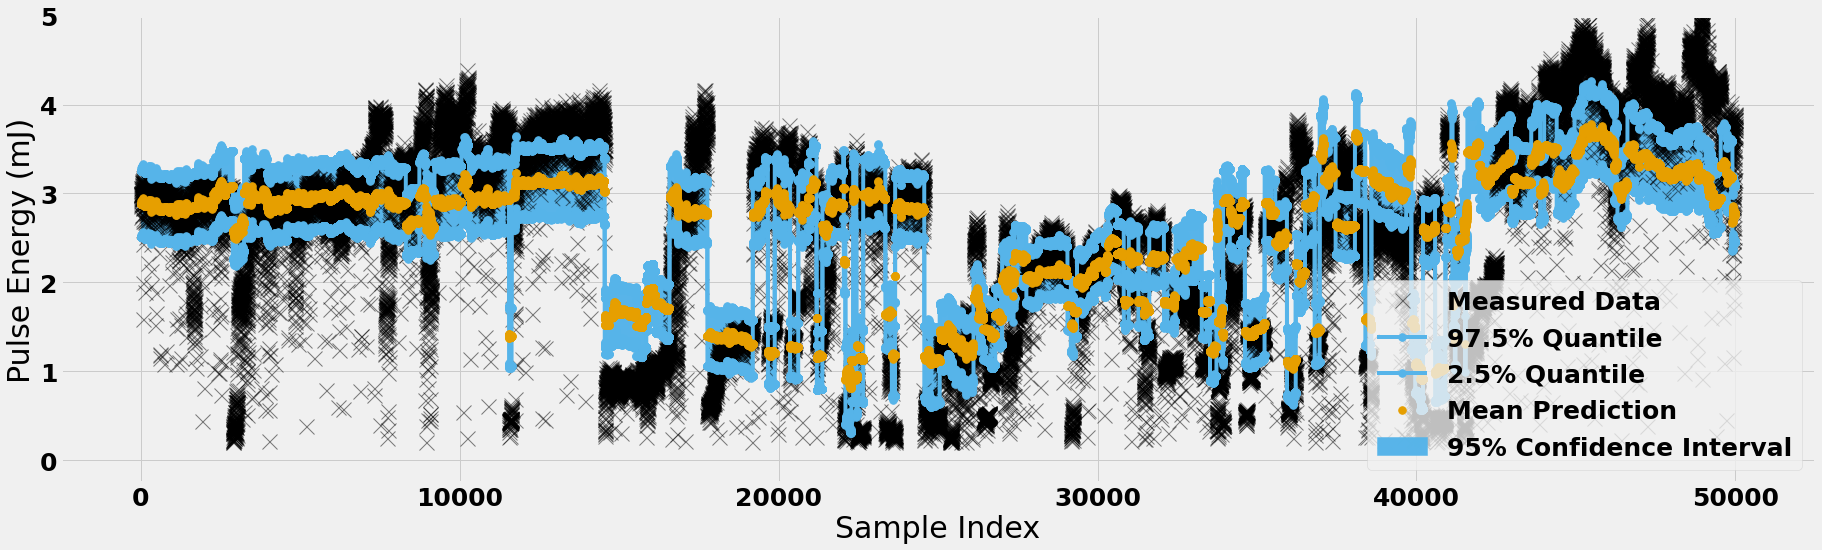

In [111]:
base = np.arange(np.shape(yreals[271543-50000:271543])[0])
#base = np.arange(271543-50000,271543)

plt.figure(figsize=(28,8))
#plt.title("BNN Results Mean Prediction and Uncertainty Estimates for FEL Pulse Energy, Chronological Data")
plt.plot(yreals[271543-50000:271543,0],'x', color = colors[0], alpha = 0.5, markersize = markersize, label= "Measured Data")
plt.plot(yu[271543-50000:271543,0],'.-', color = colors[2], markersize = markersize,label = "97.5% Quantile")
plt.plot(yl[271543-50000:271543,0],'.-', color = colors[2], markersize = markersize,label = "2.5% Quantile")

plt.plot(ymedian[271543-50000:271543,0],'.', color = colors[1],markersize = markersize,label= "Mean Prediction")

plt.fill_between(base,yu[271543-50000:271543,0],yl[271543-50000:271543,0], color = colors[2], alpha=0.99,label='95% Confidence Interval') 

plt.ylim(-0.25,5)
plt.xlabel('Sample Index')
plt.ylabel('Pulse Energy (mJ)')
#plt.tight_layout()
plt.legend(prop={'size': 25},loc = "lower right")
#plt.xlim(271543-50000,271543)
plt.savefig("BNN-alltime-zoom3.png", transparent = True, bbox_inches = 'tight')
plt.show()

In [107]:

mse, mae = calc_mse_and_mae(yreals[271543-50000:271543,0], ymedian[271543-50000:271543,0])
print("MSE = {:2.2f}".format(mse))
print("MAE = {:2.2f}".format(mae))



MSE = 0.44
MAE = 0.52


In [125]:
base = np.arange(np.shape(yreals[271543-50000:271543])[0])

out = yreals[271543-50000:271543,0]
up = yu[271543-50000:271543,0]
low = yl[271543-50000:271543,0]
med = ymedian[271543-50000:271543,0]


In [126]:
a = 20000
b = 25000
out = out[a:b]
lb_pred = low[a:b]
ub_pred = up[a:b]





In [127]:
coverage = np.logical_and(out > lb_pred, out < ub_pred)
coverage = np.array([int(elem) for elem in coverage])
coverage_percent = 100*np.sum(coverage)/len(out)

print("The percent of measured values within the confidence interval is: {:2.2f}%".format(coverage_percent))
mse, mae = calc_mse_and_mae(out, med[a:b])
print("MSE = {:2.2f}".format(mse))
print("MAE = {:2.2f}".format(mae))



The percent of measured values within the confidence interval is: 55.20%
MSE = 0.30
MAE = 0.41


In [128]:
base = np.arange(np.shape(yreals[271543-50000:271543])[0])

out = yreals[271543-50000:271543,0]
up = yu[271543-50000:271543,0]
low = yl[271543-50000:271543,0]
med = ymedian[271543-50000:271543,0]

a = 45000
b = 50000
out = out[a:b]
lb_pred = low[a:b]
ub_pred = up[a:b]

coverage = np.logical_and(out > lb_pred, out < ub_pred)
coverage = np.array([int(elem) for elem in coverage])
coverage_percent = 100*np.sum(coverage)/len(out)

print("The percent of measured values within the confidence interval is: {:2.2f}%".format(coverage_percent))
mse, mae = calc_mse_and_mae(out, med[a:b])
print("MSE = {:2.2f}".format(mse))
print("MAE = {:2.2f}".format(mae))





The percent of measured values within the confidence interval is: 17.46%
MSE = 0.73
MAE = 0.77


In [ ]:
num=100
tempnum=y_test.shape[0]
preds=np.zeros((tempnum,num))
for i in range(num):
    temp=regressor.forward(X_test)
    pred1=temp.detach().numpy()
    preds[:,i]=pred1[:,0]
tempmean=np.mean(preds,axis=1)

tempstd=np.std(preds,axis=1)
tempmean.shape,tempstd.shape
tempmedian=np.quantile(preds,0.5,axis=1)
temp075=np.quantile(preds,0.975,axis=1)
temp025=np.quantile(preds,0.025,axis=1)


yreals=scalery.inverse_transform(y_test)
ymedian=scalery.inverse_transform(tempmedian[:,np.newaxis])
yu=scalery.inverse_transform(temp075[:,np.newaxis])
yl=scalery.inverse_transform(temp025[:,np.newaxis])


idx=np.argsort(ymedian[:,0])
base=np.arange(len(idx))
#lower=yl[idx,0]
#upper=yu[idx,0]

markersize = 15
plt.figure(figsize=(30,10))
#plt.title("BNN Results: Uncertainty Estimates and Mean Prediction for FEL Pulse Energy")
plt.plot(yreals[idx,0],'x', color = colors[0], alpha = 0.5, markersize = markersize, label= "Measurement")
plt.plot(yu[idx,0],'.-', color = colors[2], markersize = markersize,label = "Upper Bound")
plt.plot(yl[idx,0],'.-', color = colors[2], markersize = markersize,label = "Lower Bound")

plt.plot(ymedian[idx,0],'.', color = colors[1],markersize = markersize,label= "BNN Mean Prediction")
#plt.fill_between(base,lower,upper,color = colors[2], alpha=0.3,label="$95$ Percentile Confidence Interval") 
plt.ylim(-0.25,5)
plt.xlabel('Sample Index')
plt.ylabel('Pulse Energy (mJ)')
plt.legend(prop={'size': 14})
#plt.savefig("BNN-test-sortedmed2.png")
plt.show()
